In [1]:
import cython

In [2]:
print(cython.__version__)

3.0.8


In [3]:
%load_ext cython

In [6]:
%%cython -f -a
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np

np.import_array()

ctypedef fused double_numeric:
    double
    double complex

from libc.stdio cimport printf
from libc.string cimport memcpy
from libcpp cimport bool as cpp_bool
from libcpp.limits cimport numeric_limits


from CyRK.utils.memory cimport shared_ptr, make_shared
from CyRK.utils.vector cimport vector
from CyRK.array.interp cimport interpj_ptr, interp_ptr, interp_complex_ptr
from CyRK cimport cysolve_ivp, CySolveOutput, PreEvalFunc, CySolverResult


from libc.math cimport NAN, INFINITY
from libc.float cimport DBL_MAX, DBL_MIN, DBL_MANT_DIG

cdef double complex cmplx_NAN
cdef double complex cmplx_zero
cdef double SQRT2
cdef double LOGE2
cdef double SQRT2_INV
cdef double THRESH
cdef double DBL_MAX_4
cdef int SCALED_CEXP_K_F
cdef int SCALED_CEXP_K_D
cdef int SCALED_CEXP_K_LD
cdef double SCALED_K_LOGE2_D
cdef float SCALED_CEXP_LOWERF
cdef float SCALED_CEXP_UPPERF
cdef double SCALED_CEXP_LOWER
cdef double SCALED_CEXP_UPPER
cdef long double SCALED_CEXP_LOWERL
cdef long double SCALED_CEXP_UPPERL

from libc.math cimport isfinite, isinf, isnan, copysign, \
    sqrt, fabs, signbit, exp, cos, sin, log, log1p, ldexp, atan2, frexp, ceil

cdef int DBL_MANT_DIG_INT = <int>DBL_MANT_DIG

SQRT2 = 1.414213562373095048801688724209698079  # sqrt 2
LOGE2 = 0.693147180559945309417232121458176568  # log_e 2

# We risk spurious overflow for components >= DBL_MAX / (1 + sqrt(2)).
SQRT2_INV = 1. / (1.0 + SQRT2)
THRESH    = SQRT2_INV * DBL_MAX
DBL_MAX_4 = 0.25 * DBL_MAX

# scaled_cexp precison constant
#if @precision@ == 1
# precision for float
SCALED_CEXP_K_F  = 235
# precision for double
SCALED_CEXP_K_D  = 1799
# precision for long double
SCALED_CEXP_K_LD = 19547

SCALED_K_LOGE2_D = SCALED_CEXP_K_D * LOGE2

SCALED_CEXP_LOWERF = 88.722839
SCALED_CEXP_UPPERF = 192.69492
SCALED_CEXP_LOWER  = 710.47586007394386
SCALED_CEXP_UPPER  = 1454.9159319953251
SCALED_CEXP_LOWERL = 11357.216553474703895
SCALED_CEXP_UPPERL = 22756.021937783004509


cdef inline double complex cf_build_dblcmplx(const double a, const double b) noexcept nogil:
    cdef double complex result
    cdef double* result_dbl_ptr = <double *> &result
    result_dbl_ptr[0] = a
    result_dbl_ptr[1] = b

    return result

cdef double INF_DBL = numeric_limits[double].infinity()
cdef double PI_DBL = 3.14159265359
cdef double G = 6.67430e-11
cdef double NAN_DBL = cmplx_NAN.real
""" Propagation of tidal solution using the fundamental matrix

References
----------
SVC16 : Sabadini, Vermeerson, & Cambiotti (2016, DOI: 10.1007/978-94-017-7552-6)
HH14  : Henning & Hurford (2014, DOI: 10.1088/0004-637X/789/1/30)
ID    : IcyDwarf Code by Marc Neveu (https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h)
B13   : Beuthe (2013, DOI: 10.1016/j.icarus.2012.11.020)
"""

from libc.math cimport NAN, isnan
from libc.stdio cimport printf, sprintf
from libc.stdlib cimport exit, EXIT_FAILURE
from libc.string cimport strcpy

from scipy.linalg.cython_lapack cimport zgesv
from CyRK cimport CySolverResult
from CyRK.utils.utils cimport allocate_mem, free_mem


from scipy.constants import G as G_
from libc.math cimport pi, sqrt


cdef void cf_non_dimensionalize_physicals(
        size_t num_radius,
        double frequency,
        double mean_radius,
        double bulk_density,
        double* radius_array_ptr,
        double* density_array_ptr,
        double_numeric* bulk_array_ptr,
        double_numeric* shear_array_ptr,
        double* radius_planet_to_use,
        double* bulk_density_to_use,
        double* frequency_to_use,
        double* G_to_use
        ) noexcept nogil:

    # Setup loop variables
    cdef size_t i

    # Setup conversions
    cdef double second2_conversion, second_conversion, length_conversion
    cdef double density_conversion, mass_conversion, pascal_conversion
    second2_conversion = 1. / (pi * G * bulk_density)
    second_conversion  = sqrt(second2_conversion)
    length_conversion  = mean_radius
    density_conversion = bulk_density
    mass_conversion    = bulk_density * mean_radius**3
    pascal_conversion  = mass_conversion / (length_conversion * second2_conversion)

    # Convert array pointers
    for i in range(num_radius):
        radius_array_ptr[i]    /= length_conversion
        density_array_ptr[i]   /= density_conversion
        bulk_array_ptr[i]      /= pascal_conversion
        shear_array_ptr[i]     /= pascal_conversion

    # Convert non-array pointers
    radius_planet_to_use[0] = 1.0
    bulk_density_to_use[0]  = 1.0
    G_to_use[0]             = G / (length_conversion**3 / (mass_conversion * second2_conversion))
    frequency_to_use[0]     = frequency / (1. / second_conversion)

cdef void cf_redimensionalize_physicals(
        size_t num_radius,
        double frequency,
        double mean_radius,
        double bulk_density,
        double* radius_array_ptr,
        double* density_array_ptr,
        double_numeric* bulk_array_ptr,
        double_numeric* shear_array_ptr,
        double* radius_planet_to_use,
        double* bulk_density_to_use,
        double* frequency_to_use,
        double* G_to_use
        ) noexcept nogil:

    # Setup loop variables
    cdef size_t i

    # Setup conversions
    cdef double second2_conversion, second_conversion, length_conversion
    cdef double density_conversion, mass_conversion, pascal_conversion
    second2_conversion = 1. / (pi * G * bulk_density)
    second_conversion  = sqrt(second2_conversion)
    length_conversion  = mean_radius
    density_conversion = bulk_density
    mass_conversion    = bulk_density * mean_radius**3
    pascal_conversion  = mass_conversion / (length_conversion * second2_conversion)

    # Convert array pointers
    for i in range(num_radius):
        radius_array_ptr[i]    *= length_conversion
        density_array_ptr[i]   *= density_conversion
        bulk_array_ptr[i]      *= pascal_conversion
        shear_array_ptr[i]     *= pascal_conversion

    # Convert non-array pointers
    radius_planet_to_use[0] = mean_radius
    bulk_density_to_use[0]  = bulk_density
    G_to_use[0]             = G
    frequency_to_use[0]     = frequency


cdef void cf_redimensionalize_radial_functions(
    double complex* radial_function_ptr,
    double mean_radius,
    double bulk_density,
    size_t num_slices,
    size_t num_solutions = 1) noexcept nogil:
    """ A function to re-dimensionalize physical parameters that have been previously non-dimensionalized.

    Parameters
    ----------
    radial_function_ptr : complex128*
        Non-dimensionalized radial solutions as a function of radius.
    mean_radius : float64
        Mean radius of the planet, used in scaling [m]
    bulk_density : float64
        Bulk density of the planet, used in scaling [m]
    num_slices : uint32
        Number of radial slices, used for looping.
    num_solutions : uint32, default=1
        Number of solutions to loop through (size of radial_function_ptr is 6 * num_solutions * num_slices)

    """
    # Loop variables
    cdef size_t slice_i, solver_i
    # Setup conversions
    cdef double second2_conversion = 1. / (pi * G * bulk_density)
    cdef double mass_conversion = bulk_density * mean_radius**3
    cdef double length_conversion = mean_radius
    cdef double length_conversion3 = length_conversion**3

    for solver_i in range(num_solutions):
        for slice_i in range(num_slices):
            # Convert displacements
            #    y1, y3 are the radial and tangential displacements with units of [s2 m-1]
            #    y2, y4 are the radial and tangential stresses with units of [kg m-3]
            #    y5 is the tidal potential which is unitless and thus needs no conversion.
            #    y6 is a "potential stress" with units of [m-1]

            radial_function_ptr[slice_i * 6 * num_solutions + solver_i * 6 + 0] *= \
                (second2_conversion / length_conversion)
            radial_function_ptr[slice_i * 6 * num_solutions + solver_i * 6 + 2] *= \
                (second2_conversion / length_conversion)

            radial_function_ptr[slice_i * 6 * num_solutions + solver_i * 6 + 1] *= \
                (mass_conversion / length_conversion3)
            radial_function_ptr[slice_i * 6 * num_solutions + solver_i * 6 + 3] *= \
                (mass_conversion / length_conversion3)

            radial_function_ptr[slice_i * 6 * num_solutions + solver_i * 6 + 4] *= \
                1.
            radial_function_ptr[slice_i * 6 * num_solutions + solver_i * 6 + 5] *= \
                (1. / length_conversion)


def non_dimensionalize_physicals(
        double frequency,
        double mean_radius,
        double bulk_density,
        double[::1] radius_array_view,
        double[::1] density_array_view,
        double_numeric[::1] bulk_array_view,
        double_numeric[::1] shear_array_view,
        ):

    cdef size_t num_radius = radius_array_view.size
    cdef double radius_planet_to_use, bulk_density_to_use, frequency_to_use, G_to_use
    
    cf_non_dimensionalize_physicals(
        num_radius, frequency, mean_radius, bulk_density,
        &radius_array_view[0], &density_array_view[0], 
        &bulk_array_view[0], &shear_array_view[0],
        &radius_planet_to_use, &bulk_density_to_use, &frequency_to_use, &G_to_use
        )
    
    return frequency_to_use, G_to_use

def redimensionalize_physicals(
        double frequency,
        double mean_radius,
        double bulk_density,
        double[::1] radius_array_view,
        double[::1] density_array_view,
        double[::1] bulk_array_view,
        double_numeric[::1] shear_array_view,
        ):

    cdef size_t num_radius = radius_array_view.size
    cdef double radius_planet_to_use, bulk_density_to_use, frequency_to_use, G_to_use
    
    cf_redimensionalize_physicals(
        num_radius, frequency, mean_radius, bulk_density,
        &radius_array_view[0], &density_array_view[0],
        &bulk_array_view[0], &shear_array_view[0],
        &radius_planet_to_use, &bulk_density_to_use, &frequency_to_use, &G_to_use
        )
    
    return frequency_to_use, G_to_use

def redimensionalize_radial_functions(
    double complex[:, ::1] radial_function_view,
    double mean_radius,
    double bulk_density):
    """ A function to re-dimensionalize physical parameters that have been previously non-dimensionalized.

    Parameters
    ----------
    radial_function_view : double complex[:, ::1]
        Non-dimensionalized radial solutions as a function of radius.
    mean_radius : float64
        Mean radius of the planet, used in scaling [m]
    bulk_density : float64
        Bulk density of the planet, used in scaling [m]
    num_slices : uint32
        Number of radial slices, used for looping.
    num_solutions : uint32, default=1
        Number of solutions to loop through (size of radial_function_ptr is 6 * num_solutions * num_slices)

    """
    # Size of arrays
    cdef size_t num_solutions, num_slices
    num_solutions = <size_t> (radial_function_view.shape[0] / 6)
    num_slices = radial_function_view.shape[1]

    # Call cython function
    cf_redimensionalize_radial_functions(
        &radial_function_view.T[0, 0],
        mean_radius,
        bulk_density,
        num_slices,
        num_solutions
    )


import numpy as np
cimport numpy as np

from libc.stdio cimport printf
from libc.stdlib cimport exit
from libc.math cimport NAN


cdef void cf_get_surface_bc(
    double* boundary_conditions_ptr,
    int* bc_model_ptr,
    size_t num_bcs,
    double radius_to_use,
    double bulk_density_to_use,
    double degree_l_dbl,
    ) noexcept nogil:
    """Find the surface boundary condition. """

    # `num_bcs` should equal the length of `bc_model_ptr`
    if num_bcs > 5:
        printf(
            "Unsupported number of boundaries conditions encountered."
            " Provided: %d when maximum supported is 5.", num_bcs)
        exit(-1)
    elif num_bcs <= 0:
        printf(
            "Unsupported number of boundaries conditions encountered."
            " Provided: %d when minimum supported is 1.", num_bcs)
        exit(-1)
    cdef size_t i, j

    # Inititalize all boundary conditions to NaN
    # 15 = 5 (max_num_solutions) * 3 (number of surface conditions)
    for i in range(15):
        boundary_conditions_ptr[i] = NAN
    
    for j in range(num_bcs):
        if bc_model_ptr[j] == 0:
            # Free Surface
            boundary_conditions_ptr[j * 3 + 0] = 0.
            boundary_conditions_ptr[j * 3 + 1] = 0.
            boundary_conditions_ptr[j * 3 + 2] = 0.
        elif bc_model_ptr[j] == 1:
            # Tidal Potential
            boundary_conditions_ptr[j * 3 + 0] = 0.
            boundary_conditions_ptr[j * 3 + 1] = 0.
            boundary_conditions_ptr[j * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_to_use
        elif bc_model_ptr[j] == 2:
            # Loading Potential
            boundary_conditions_ptr[j * 3 + 0] = (-1. / 3.) * (2. * degree_l_dbl + 1.) * bulk_density_to_use
            boundary_conditions_ptr[j * 3 + 1] = 0.
            boundary_conditions_ptr[j * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_to_use
        else:
            printf(
                "Unknown boundary condition model: %d. Supported models are:\n"
                " 0: Free Surface.\n"
                " 1: Tidal Potential.\n"
                " 2: Loading Potential.\n", bc_model_ptr[j])
            exit(-1)


def get_surface_bc(
    int[::1] bc_model_view,
    double radius_to_use,
    double bulk_density_to_use,
    double degree_l_dbl,
    ):

    cdef int* bc_model_ptr = &bc_model_view[0]
    cdef size_t num_bcs = bc_model_view.size

    # Build output array
    cdef np.ndarray[np.float64_t, ndim=1] boundary_conditions_arr = np.empty(15, dtype=np.float64)
    cdef double[::1] boundary_conditions_view = boundary_conditions_arr
    cdef double* boundary_conditions_ptr = &boundary_conditions_view[0]
    cf_get_surface_bc(
        boundary_conditions_ptr,
        bc_model_ptr,
        num_bcs,
        radius_to_use,
        bulk_density_to_use,
        degree_l_dbl,
        )
    
    return boundary_conditions_arr

from libc.math cimport pi

from cython.parallel cimport prange

from TidalPy.utilities.constants_x cimport G
from TidalPy.utilities.math.complex cimport cf_cinv


cdef void cf_fundamental_matrix(
        Py_ssize_t num_radial_slices,
        double* radius_array_ptr,
        double* density_array_ptr,
        double* gravity_array_ptr,
        double complex* complex_shear_array_ptr,
        double complex* fundamental_mtx_ptr,
        double complex* inverse_fundamental_mtx_ptr,
        double complex* derivative_mtx_ptr,
        unsigned char degree_l = 2,
        double G_to_use = G
        ) noexcept nogil:
    """ Construct the fundamental matrix and its inverse for a generic order-l

    See Eq. 2.42 of SVC16

    Assumptions
    -----------
    - These matrices assume an incompressible body.

    Parameters
    ----------
    num_radial_slices : Py_ssize_t
        Number of radial slices
    radius_array_ptr : double
        Pointer to array of Radius values [m]
    density_array_ptr : double
        Pointer to array of Density at each radius [kg m-3]
    gravity_array_ptr : double
        Pointer to array_ptr of acceleration due to gravity at each radius [m s-2]
    complex_shear_array : double complex
        Pointer to array of Complex shear modulus at each radius [Pa]
    fundamental_mtx_ptr : double complex*
        _Return Value_
        6 x 6 matrix of double complex values
        Fundamental matrix used in the propagation technique
    inverse_fundamental_mtx_ptr : double complex*
        _Return Value_
        The inverse of the fundamental matrix used in the propagation technique
    derivative_mtx_ptr : double complex*
        _Return Value_
        The matrix, A, that satisfies the equation dy/dr = A * y
    degree_l : unsigned char, default=2
        Harmonic degree.
    G_to_use : double, default=G
        Gravitational constant used in calculations. Can be provided for non-dimensionalized solutions.
    """

    cdef Py_ssize_t r_i, index_shift
    
    cdef double radius, gravity, density
    cdef double complex complex_shear
    
    cdef double r_inv, rl, rlp1, rlp2, rlp3, rnl, rnlm2, rlm1, rgp, piGp
    cdef double coeff, d_coeff_1, d_coeff_2, d_coeff_3, d_coeff_4, d_coeff_5, d_coeff_6
    cdef double complex mu_inv, rgp_s, r_s, pr_s

    # Degree-l Optimizations
    cdef double degree_l_dbl = <double> degree_l
    cdef double dlm1         = (2. * degree_l_dbl - 1.)
    cdef double l2p3lm1      = (degree_l_dbl**2 + 3. * degree_l_dbl - 1.)
    cdef double l2mlm3       = (degree_l_dbl**2 - degree_l_dbl - 3.)
    cdef double lp1          = (degree_l_dbl + 1.)
    cdef double lp2          = (degree_l_dbl + 2.)
    cdef double lp3          = (degree_l_dbl + 3.)
    cdef double l2m1         = (degree_l_dbl**2 - 1.)
    cdef double dlp1         = (2. * degree_l_dbl + 1.)
    cdef double dlp3         = (2. * degree_l_dbl + 3.)

    for r_i in prange(num_radial_slices):

        # Shift index by 36 (for the inner 6x6 matrix)
        index_shift = r_i * 36

        # Unpack radially dependent variables
        radius        = radius_array_ptr[r_i]
        complex_shear = complex_shear_array_ptr[r_i]
        gravity       = gravity_array_ptr[r_i]
        density       = density_array_ptr[r_i]

        # Radius-based optimizations
        r_inv  = 1. / radius
        mu_inv = cf_cinv(complex_shear)
        rl     = radius**degree_l
        rlp1   = radius**(degree_l + 1)
        rlp2   = radius**(degree_l + 2)
        rlp3   = radius**(degree_l + 3)
        rnl    = radius**(-degree_l)
        rnlm2  = radius**(-degree_l - 2)
        rlm1   = radius**(degree_l - 1)
        rgp    = radius * gravity * density
        rgp_s  = rgp * mu_inv
        r_s    = radius * mu_inv
        pr_s   = density * r_s
        piGp   = pi * G_to_use * density
        
        # D Coefficients
        coeff = (1. / dlp1)
        d_coeff_1 = coeff * lp1 / rlp1
        d_coeff_2 = coeff * degree_l_dbl * lp1 / (2. * dlm1 * rlm1)
        d_coeff_3 = coeff * 1. / rlm1
        d_coeff_4 = coeff * degree_l_dbl * rl
        d_coeff_5 = coeff * rlp2 * degree_l_dbl * lp1 / (2. * dlp3)
        d_coeff_6 = coeff * -rlp1

        
        # Build Fundamental Matrix (zeros do not need to be specifically stated as they were put in at initialization)
        #     Eq. 2.42 in SVC
        ## Row 1
        fundamental_mtx_ptr[index_shift + 0]  = degree_l_dbl * rlp1 / (2. * dlp3)
        fundamental_mtx_ptr[index_shift + 1]  = rlm1
        fundamental_mtx_ptr[index_shift + 2]  = 0.
        fundamental_mtx_ptr[index_shift + 3]  = lp1 * rnl / (2. * dlm1)
        fundamental_mtx_ptr[index_shift + 4]  = rnlm2
        fundamental_mtx_ptr[index_shift + 5]  = 0.

        ## Row 2
        fundamental_mtx_ptr[index_shift + 6]  = lp3 * rlp1 / (2. * dlp3 * lp1)
        fundamental_mtx_ptr[index_shift + 7]  = rlm1 / degree_l_dbl
        fundamental_mtx_ptr[index_shift + 8]  = 0.
        fundamental_mtx_ptr[index_shift + 9]  = (2. - degree_l_dbl) * rnl / (2. * degree_l_dbl * dlm1)
        fundamental_mtx_ptr[index_shift + 10] = -rnlm2 / lp1
        fundamental_mtx_ptr[index_shift + 11] = 0.

        ## Row 3
        # RECORD: Believe there is a typo in HH14, they have the radius^l only on one term instead of both.
        fundamental_mtx_ptr[index_shift + 12] = (degree_l_dbl * rgp + 2. * l2mlm3 * complex_shear) * rl / (2. * dlp3)
        fundamental_mtx_ptr[index_shift + 13] = (rgp + 2. * (degree_l_dbl - 1.) * complex_shear) * radius**(degree_l_dbl - 2.)
        fundamental_mtx_ptr[index_shift + 14] = -density * rl
        fundamental_mtx_ptr[index_shift + 15] = (lp1 * rgp - 2. * l2p3lm1 * complex_shear) / (2. * dlm1 * rlp1)
        fundamental_mtx_ptr[index_shift + 16] = (rgp - 2. * lp2 * complex_shear) / rlp3
        fundamental_mtx_ptr[index_shift + 17] = -density / rlp1

        ## Row 4
        fundamental_mtx_ptr[index_shift + 18] = degree_l_dbl * lp2 * complex_shear * rl / (dlp3 * lp1)
        fundamental_mtx_ptr[index_shift + 19] = 2 * (degree_l_dbl - 1.) * complex_shear * radius**(degree_l_dbl - 2.) / degree_l_dbl
        fundamental_mtx_ptr[index_shift + 20] = 0.
        fundamental_mtx_ptr[index_shift + 21] = l2m1 * complex_shear / (degree_l_dbl * dlm1 * rlp1)
        fundamental_mtx_ptr[index_shift + 22] = 2. * lp2 * complex_shear / (lp1 * rlp3)
        fundamental_mtx_ptr[index_shift + 23] = 0.

        ## Row 5
        fundamental_mtx_ptr[index_shift + 24] = 0.
        fundamental_mtx_ptr[index_shift + 25] = 0.
        fundamental_mtx_ptr[index_shift + 26] = -rl
        fundamental_mtx_ptr[index_shift + 27] = 0.
        fundamental_mtx_ptr[index_shift + 28] = 0.
        fundamental_mtx_ptr[index_shift + 29] = -1. / rlp1

        ## Row 6
        fundamental_mtx_ptr[index_shift + 30] = 2. * piGp * degree_l_dbl * rlp1 / dlp3
        fundamental_mtx_ptr[index_shift + 31] = 4. * piGp * rlm1
        fundamental_mtx_ptr[index_shift + 32] = -dlp1 * rlm1
        fundamental_mtx_ptr[index_shift + 33] = 2 * piGp * lp1 / (dlm1 * rl)
        fundamental_mtx_ptr[index_shift + 34] = 4. * piGp / rlp2
        fundamental_mtx_ptr[index_shift + 35] = 0.

        # Inverse of the Fundamental Matrix
        # This function manually defines the inverse matrix which is about 15--30% faster than a version that uses
        #    np.linalg.inv() to calculate the inverse matrix.
        #
        # From SVC16 Eq. 2.45: Fundamental Inverse = D_Mtx * Y^Bar_Mtx
        # D_Mtx is a diagonal matrix with
        # 1/(2l+1) * [ ... ]
        # We are going to multiple first and just write down the fundamental matrix inverse to avoid the additional D*Ybar
        #    calculation.

        ## Row 1
        inverse_fundamental_mtx_ptr[index_shift + 0]  = d_coeff_1 * (rgp_s - 2. * lp2)
        inverse_fundamental_mtx_ptr[index_shift + 1]  = d_coeff_1 * (2. * degree_l_dbl * lp2)
        inverse_fundamental_mtx_ptr[index_shift + 2]  = d_coeff_1 * (-r_s)
        inverse_fundamental_mtx_ptr[index_shift + 3]  = d_coeff_1 * (degree_l_dbl * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 4]  = d_coeff_1 * (pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 5]  = 0.

        ## Row 2
        inverse_fundamental_mtx_ptr[index_shift + 6]  = d_coeff_2 * (-rgp_s + 2. * l2p3lm1 / lp1)
        inverse_fundamental_mtx_ptr[index_shift + 7]  = d_coeff_2 * (-2. * l2m1)
        inverse_fundamental_mtx_ptr[index_shift + 8]  = d_coeff_2 * (r_s)
        inverse_fundamental_mtx_ptr[index_shift + 9]  = d_coeff_2 * ((2. - degree_l_dbl) * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 10] = d_coeff_2 * (-pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 11] = 0.

        ## Row 3
        inverse_fundamental_mtx_ptr[index_shift + 12] = d_coeff_3 * (4. * piGp)
        inverse_fundamental_mtx_ptr[index_shift + 13] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 14] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 15] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 16] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 17] = -d_coeff_3

        ## Row 4
        inverse_fundamental_mtx_ptr[index_shift + 18] = d_coeff_4 * (rgp_s + 2. * (degree_l_dbl - 1.))
        inverse_fundamental_mtx_ptr[index_shift + 19] = d_coeff_4 * (2. * l2m1)
        inverse_fundamental_mtx_ptr[index_shift + 20] = d_coeff_4 * (-r_s)
        inverse_fundamental_mtx_ptr[index_shift + 21] = d_coeff_4 * (-lp1 * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 22] = d_coeff_4 * (pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 23] = 0.

        ## Row 5
        inverse_fundamental_mtx_ptr[index_shift + 24] = d_coeff_5 * (-rgp_s - 2. * l2mlm3 / degree_l_dbl)
        inverse_fundamental_mtx_ptr[index_shift + 25] = d_coeff_5 * (-2. * degree_l_dbl * lp2)
        inverse_fundamental_mtx_ptr[index_shift + 26] = d_coeff_5 * (r_s)
        inverse_fundamental_mtx_ptr[index_shift + 27] = d_coeff_5 * (lp3 * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 28] = d_coeff_5 * (-pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 29] = 0.

        ## Row 6
        inverse_fundamental_mtx_ptr[index_shift + 30] = d_coeff_6 * (4. * piGp * radius)
        inverse_fundamental_mtx_ptr[index_shift + 31] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 32] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 33] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 34] = d_coeff_6 * dlp1
        inverse_fundamental_mtx_ptr[index_shift + 35] = d_coeff_6 * (-radius)

        # Build derivative matrix
        # Defined in SV04 -- Only valid for the incompressible case.
        # See SVC16 Eq. 1.95
        #    Note: the lambda in SVC16 is defined as bulk_mod - (2. / 3.) * shear (Eq. 1.77; 2nd Lame parameter),
        #    for the incompressible assumption we will assume the ratio that SVC16 use (lambda / beta) -> 1 as K -> inf
        #    See SVC16 Eq. 1.95 for a compressible version. Take limit as K->inf to find below.
        ## Row 1
        derivative_mtx_ptr[index_shift + 0]  = -2. * r_inv
        derivative_mtx_ptr[index_shift + 1]  = degree_l_dbl * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 2]  = 0.
        derivative_mtx_ptr[index_shift + 3]  = 0.
        derivative_mtx_ptr[index_shift + 4]  = 0.
        derivative_mtx_ptr[index_shift + 5]  = 0.

        ## Row 2
        derivative_mtx_ptr[index_shift + 6]  = -1. * r_inv
        derivative_mtx_ptr[index_shift + 7]  = r_inv
        derivative_mtx_ptr[index_shift + 8]  = 0.
        derivative_mtx_ptr[index_shift + 9]  = mu_inv
        derivative_mtx_ptr[index_shift + 10] = 0.
        derivative_mtx_ptr[index_shift + 11] = 0.

        ## Row 3
        derivative_mtx_ptr[index_shift + 12] = (4. * r_inv) * (3. * complex_shear * r_inv - density * gravity)
        derivative_mtx_ptr[index_shift + 13] = -degree_l_dbl * lp1 * r_inv * (6. * complex_shear * r_inv - density * gravity)
        derivative_mtx_ptr[index_shift + 14] = 0.
        derivative_mtx_ptr[index_shift + 15] = degree_l_dbl * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 16] = -density * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 17] = density

        ## Row 4
        derivative_mtx_ptr[index_shift + 18] = (-1. * r_inv) * (6. * complex_shear * r_inv - density * gravity)
        derivative_mtx_ptr[index_shift + 19] = 2. * (2. * degree_l_dbl**2 + 2. * degree_l_dbl - 1.) * complex_shear * (r_inv**2)
        derivative_mtx_ptr[index_shift + 20] = -r_inv
        derivative_mtx_ptr[index_shift + 21] = -3. * r_inv
        derivative_mtx_ptr[index_shift + 22] = density * r_inv
        derivative_mtx_ptr[index_shift + 23] = 0.

        ## Row 5
        derivative_mtx_ptr[index_shift + 24] = -4. * piGp
        derivative_mtx_ptr[index_shift + 25] = 0.
        derivative_mtx_ptr[index_shift + 26] = 0.
        derivative_mtx_ptr[index_shift + 27] = 0.
        derivative_mtx_ptr[index_shift + 28] = -lp1 * r_inv
        derivative_mtx_ptr[index_shift + 29] = 1.

        ## Row 6
        derivative_mtx_ptr[index_shift + 30] = -4. * piGp * (degree_l_dbl + 1) * r_inv
        derivative_mtx_ptr[index_shift + 31] = 4. * piGp * degree_l_dbl * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 32] = 0.
        derivative_mtx_ptr[index_shift + 33] = 0.
        derivative_mtx_ptr[index_shift + 34] = 0.
        derivative_mtx_ptr[index_shift + 35] = (degree_l_dbl - 1.) * r_inv


def fundamental_matrix(
        double[::1] radius_array_view,
        double[::1] density_array_view,
        double[::1] gravity_array_view,
        double complex[::1] complex_shear_array_view,
        double complex[:, :, ::1] fundamental_mtx_view,
        double complex[:, :, ::1] fundamental_mtx_inverse_view,
        double complex[:, :, ::1] derivative_mtx_view,  
        unsigned char degree_l = 2,
        double G_to_use = G
        ):
    """ Construct the fundamental matrix and its inverse using harmonic degree l.

    See Eq. 2.42 of SVC16

    Assumptions
    -----------
    - These matrices assume an incompressible body.

    Parameters
    ----------
    radius_array_view : double
        Pointer to array of Radius values [m]
    density_array_view : double
        Pointer to array of Density at each radius [kg m-3]
    gravity_array_view : double
        Pointer to array of acceleration due to gravity at each radius [m s-2]
    complex_shear_array_view : double complex
        Pointer to array of Complex shear modulus at each radius [Pa]
    fundamental_mtx_view : double complex[:, ::1]
        _Return Value_
        Fundamental matrix used in the propagation technique
    fundamental_mtx_inverse_view : double complex[:, ::1]
        _Return Value_
        The inverse of the fundamental matrix used in the propagation technique
    derivative_mtx_view : double complex[:, ::1]
        _Return Value_
        The matrix, A, that satisfies the equation dy/dr = A * y
    degree_l : unsigned char, default=2
        Harmonic degree.
    G_to_use : double, default=G
        Gravitational constant used in calculations. Can be provided for non-dimensionalized solutions.
    """ 

    cdef Py_ssize_t num_radial_slices
    num_radial_slices = len(radius_array_view)

    # Check for unexpected shapes and sizes of return matrices
    if len(density_array_view) != num_radial_slices:
        raise ValueError('Unexpected size encountered for density array.')
    if len(gravity_array_view) != num_radial_slices:
        raise ValueError('Unexpected size encountered for gravity array.')
    if len(complex_shear_array_view) != num_radial_slices:
        raise ValueError('Unexpected size encountered for complex shear array.')
    if (fundamental_mtx_view.shape[0] != num_radial_slices) or \
            (fundamental_mtx_view.shape[1] != 6) or \
            (fundamental_mtx_view.shape[2] != 6):
        raise ValueError('Unexpected shape encountered for Fundamental Matrix.')
    if (fundamental_mtx_inverse_view.shape[0] != num_radial_slices) or \
            (fundamental_mtx_inverse_view.shape[1] != 6) or \
            (fundamental_mtx_inverse_view.shape[2] != 6):
        raise ValueError('Unexpected shape encountered for Fundamental Matrix (inv).')
    if (derivative_mtx_view.shape[0] != num_radial_slices) or \
            (derivative_mtx_view.shape[1] != 6) or \
            (derivative_mtx_view.shape[2] != 6):
        raise ValueError('Unexpected shape encountered for Derivative Matrix.')

    # Call cdef function.
    cf_fundamental_matrix(
        num_radial_slices,
        &radius_array_view[0],
        &density_array_view[0],
        &gravity_array_view[0],
        &complex_shear_array_view[0],
        &fundamental_mtx_view[0, 0, 0],
        &fundamental_mtx_inverse_view[0, 0, 0],
        &derivative_mtx_view[0, 0, 0],
        degree_l,
        G_to_use
    )

cdef int MAX_NUM_Y = 6


cdef void cf_matrix_propagate(
        RadialSolutionStorageCC* solution_storage_ptr,
        size_t total_slices,
        double* radius_array_ptr,
        double frequency,
        double planet_bulk_density,
        EOSSolutionVec* eos_solution_bylayer_ptr,
        size_t num_layers,
        # TODO: In the future the propagation matrix should take in layer types and multiple layers
        # int* layer_types_ptr,
        # int* is_static_by_layer_ptr,
        # int* is_incompressible_by_layer_ptr,
        double* upper_radius_by_layer_ptr,
        size_t num_bc_models,
        int* bc_models_ptr,
        double G_to_use = G,
        unsigned int degree_l = 2,
        unsigned char core_condition = 0,
        cpp_bool nondimensionalize = True,
        cpp_bool verbose = False,
        cpp_bool raise_on_fail = False,
        cpp_bool already_nondimed = False
        ) noexcept nogil:

    # Setup
    cdef size_t r_i, i, j, k, jj, ytype_i, slice_i
    cdef size_t last_index_shift_36, index_shift_36, last_index_shift_18, index_shift_18, index_shift_max_y, full_shift
    cdef cpp_bool error = False
    strcpy(solution_storage_ptr.message_ptr, "RadialSolver.PropMatrixMethod:: Propagator Matrix Method Called.\n")

    # Create gravity and density arrays used to build the matrices
    cdef vector[double] density_array_vec               = vector[double](0)
    cdef vector[double] gravity_array_vec               = vector[double](0)
    cdef vector[double complex] complex_shear_array_vec = vector[double](0)
    # TODO: Bulk modulus is not used in the propagation matrix method.
    cdef vector[double complex] complex_bulk_array_vec  = vector[double](0)
    density_array_vec.reserve(total_slices)
    gravity_array_vec.reserve(total_slices)
    complex_shear_array_vec.reserve(total_slices)
    complex_bulk_array_vec.reserve(total_slices)
    cdef double* density_array_ptr               = &density_array_vec[0]
    cdef double* gravity_array_ptr               = &gravity_array_vec[0]
    cdef double complex* complex_shear_array_ptr = &complex_shear_array_vec[0]
    cdef double complex* complex_bulk_array_ptr  = &complex_bulk_array_vec[0]

    # Build storage used to call the EOS at each radius
    # The EOS stores 7 doubles:
    #   0: Gravity
    #   1: Pressure
    #   2: Density
    #   3: Shear Mod (real)
    #   4: Shear Mod (imag)
    #   5: Bulk Mod (real)
    #   6: Bulk Mod (imag)
    cdef vector[double] y_array = vector[double](7)
    cdef double* y_array_ptr    = &y_array[0]

    # Build variables to help solve the EOS.
    cdef double r
    cdef int current_layer_i = 0
    cdef double layer_r      = upper_radius_by_layer_ptr[current_layer_i]
    cdef CySolverResult* eos_solution_ptr = eos_solution_bylayer_ptr[current_layer_i]

    # Step through the radial steps to find EOS-dependent parameters
    for i in range(total_slices):
        r = radius_array_ptr[i]

        # Check if we are using the correct EOS solution (changes with layers)
        if r > layer_r:
            current_layer_i += 1
            layer_r = upper_radius_by_layer_ptr[current_layer_i]
            eos_solution_ptr = eos_solution_bylayer_ptr[current_layer_i]

        # Call the dense output of the EOS ODE solution to populate the y_interp pointer.
        eos_solution_ptr.cyresult_ptr.call(r, y_array_ptr)

        # Store results
        gravity_array_ptr[i]       = y_array_ptr[0]
        # Skip pressure at y-interp index 1
        density_array_ptr[i]       = y_array_ptr[2]
        complex_shear_array_ptr[i] = cf_build_dblcmplx(y_array_ptr[3], y_array_ptr[4])
        complex_bulk_array_ptr[i]  = cf_build_dblcmplx(y_array_ptr[5], y_array_ptr[6])

    # Nondimensional variables
    cdef double mean_radius          = radius_array_ptr[total_slices - 1]
    cdef double planet_radius_to_use = NAN
    cdef double bulk_density_to_use  = NAN
    cdef double frequency_to_use     = NAN
    cdef double G_to_use             = NAN

    if nondimensionalize and (not already_nondimed):
        cf_non_dimensionalize_physicals(
            total_slices, frequency, mean_radius, planet_bulk_density, radius_array_ptr, density_array_ptr,
            gravity_array_ptr, complex_bulk_array_ptr, complex_shear_array_ptr,
            &planet_radius_to_use, &bulk_density_to_use, &frequency_to_use, &G_to_use
            )
        
        # Ensure that no errors occured during the non-dim process
        if isnan(planet_radius_to_use) or isnan(bulk_density_to_use) or isnan(frequency_to_use) or isnan(G_to_use):
            strcpy(solution_storage_ptr.message_ptr, "RadialSolver.PropMatrixMethod:: NaNs encountered after non-dimensionalize call.\n")
            error = True
            if verbose or raise_on_fail:
                printf(solution_storage_ptr.message_ptr)
            if raise_on_fail:
                exit(EXIT_FAILURE)
    else:
        # Leave inputs alone.
        planet_radius_to_use = mean_radius
        bulk_density_to_use  = planet_bulk_density
        frequency_to_use     = frequency

    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    # The [5] represents the maximum number of solvers that can be invoked with a single call to radial_solver
    cdef double degree_l_dbl      = <double>degree_l
    cdef size_t max_num_solutions = 5
    cdef size_t num_ytypes        = num_bc_models

    # Boundary condition size: 15 = 5 (max_num_solutions) * 3 (number of surface conditions)
    cdef double[15] boundary_conditions
    cdef double* bc_pointer = &boundary_conditions[0]
    cf_get_surface_bc(
        bc_pointer,  # Changed parameter
        bc_models_ptr,
        num_ytypes,
        planet_radius_to_use,
        bulk_density_to_use,
        degree_l_dbl
        )

    # Define memory for our fundamental matricies.
    # These have to be heap allocated because we do not know the number of radial slices at compile time (and it could be large)
    cdef size_t matrix_size = 6 * 6 * total_slices
    cdef double complex* fundamental_mtx_ptr
    cdef double complex* inverse_fundamental_mtx_ptr
    cdef double complex* derivative_mtx_ptr
    cdef double complex* propagation_mtx_ptr

    fundamental_mtx_ptr = <double complex *>allocate_mem(
        sizeof(double complex) * matrix_size,
        "`fundamental_mtx_ptr` (cf_matrix_propagate)"
        )
    inverse_fundamental_mtx_ptr = <double complex *>allocate_mem(
        sizeof(double complex) * matrix_size,
        "`inverse_fundamental_mtx_ptr` (cf_matrix_propagate)"
        )
    derivative_mtx_ptr = <double complex *>allocate_mem(
        sizeof(double complex) * matrix_size,
        "`derivative_mtx_ptr` (cf_matrix_propagate)"
        )
    
    # Propagation matrix has 6 rows but only 3 columns.
    cdef size_t prop_mat_size = 6 * 3 * total_slices
    propagation_mtx_ptr = <double complex *>allocate_mem(
        sizeof(double complex) * prop_mat_size,
        "`propagation_mtx_ptr` (cf_matrix_propagate)"
        )

    # Populate matricies with the correct layer type. 
    # TODO: Currently only solid, static, incompressible layers are supported for matrix propagation.
    cf_fundamental_matrix(
        total_slices,
        radius_array_ptr,
        density_array_ptr,
        gravity_array_ptr,
        complex_shear_array_ptr,
        fundamental_mtx_ptr,  # Changed variable
        inverse_fundamental_mtx_ptr,  # Changed variable
        derivative_mtx_ptr,  # Changed variable
        degree_l,
        G_to_use
        )

    # Initialize the base of the propagation matrix to the initial conditions
    ## From IcyDwarf: "They are inconsequential on the rest of the solution, so false assumptions are OK."
    # TODO Add more of these.
    if core_condition == 0:
        # Henning & Hurford (2014): "At the core, a special seed matrix Bcore is created with only three columns,
        # equal to the first, second, and third columns of Y for the properties at the base layer."
        for j in range(6):
            for k in range(3):
                propagation_mtx_ptr[j * 6 + k] = fundamental_mtx_ptr[j * 6 + k]
    elif core_condition == 1:
        # Roberts & Nimmo (2008): liquid innermost zone.
        for j in range(6):
            for k in range(3):
                if (j == 2) and (k == 0):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(1., 0.)
                elif (j == 3) and (k == 1):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(1., 0.)
                elif (j == 5) and (k == 2):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(1., 0.)
                else:
                    propagation_mtx_ptr[j * 6 + k] = cmplx_zero
    elif core_condition == 2:
        # Solid innermost zone
        for j in range(6):
            for k in range(3):
                if (j == 0) and (k == 0):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(1., 0.)
                elif (j == 1) and (k == 1):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(1., 0.)
                elif (j == 2) and (k == 2):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(1., 0.)
                else:
                    propagation_mtx_ptr[j * 6 + k] = cmplx_zero
    elif core_condition == 3:
        # Solid innermost zone
        for j in range(6):
            for k in range(3):
                if (j == 0) and (k == 0):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(0.05, 0.)
                elif (j == 1) and (k == 1):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(0.01, 0.)
                elif (j == 5) and (k == 2):
                    propagation_mtx_ptr[j * 6 + k] = cf_build_dblcmplx(1., 0.)
                else:
                    propagation_mtx_ptr[j * 6 + k] = cmplx_zero
    else:
        sprintf(solution_storage_ptr.message_ptr, "RadialSolver.PropMatrixMethod:: Unknown starting core conditions encountered in `cf_matrix_propagate`: %d (acceptible values: 0, 1, 2, 3)\n", core_condition)
        error = True
        if verbose or raise_on_fail:
            printf(solution_storage_ptr.message_ptr)
        if raise_on_fail:
            exit(EXIT_FAILURE)

    # Step through the planet's shells and build the propagation matrix
    # Need to find the inverse of the surface matrix (3 x 3)
    # We will use a linear equation solver to solve: surface_solution = surface_matrix^-1 @ surface_bc
    # Re-arranged: surface_matrix @ surface_solution = surface_bc
    # ZGESV computes the solution to system of linear equations A * X = B for GE matrices
    # See https://www.netlib.org/lapack/explore-html/d8/da6/group__gesv_ga0850dc117a6c7ec3cb64905d5de1cd23.html#ga0850dc117a6c7ec3cb64905d5de1cd23
    
    # Create the ZGESV "A" variable
    cdef double complex[9] surface_matrix
    cdef double complex* surface_matrix_ptr = &surface_matrix[0]
    cdef double complex[9] surface_matrix_copy
    cdef double complex* surface_matrix_copy_ptr = &surface_matrix_copy[0]

    cdef double complex temp_cmplx
    cdef double complex[18] temp_matrix
    cdef double complex* temp_matrix_ptr = &temp_matrix[0]

    # Create the ZGESV "X" variable
    cdef double complex[3] surface_solution
    cdef double complex* surface_solution_ptr = &surface_solution[0]

    # Create a copy of ZGESV "B" surface boundary condition because it is overwritten with each call of zgesv
    cdef double complex[3] bc_copy
    cdef double complex* bc_copy_ptr = &bc_copy[0]

    # Initialize surface matrix and temp_matrix to nan to help with debugging
    for j in range(18):
        if j < 3:
            surface_solution_ptr[j] = cmplx_NAN
            bc_copy_ptr[j] = cmplx_NAN
        if j < 9:
            surface_matrix_ptr[j] = cmplx_NAN
            surface_matrix_copy_ptr[j] = cmplx_NAN
        temp_matrix_ptr[j] = cmplx_NAN

    for r_i in range(1, total_slices):
        
        # Need to start the index for this radial slice. The shift is based on the size of the respective matrix.
        # Fundamental matrix is 6x6
        index_shift_36 = r_i * 36
        last_index_shift_36 = (r_i - 1) * 36
        # Propagation matrix is 6x3
        index_shift_18 = r_i * 18
        last_index_shift_18 = (r_i - 1) * 18

        # The function we are performing here is:
        # P_{i} = Y_{i} @ ( Y_{i-1}^{-1} @ P_{i-1} )

        # Perform the first matrix multiplication
        # A = Y_{i-1}^{-1} @ P_{i-1}
        for j in range(6):
            for k in range(3):
                temp_cmplx = cf_build_dblcmplx(0., 0.)
                for jj in range(6):
                    temp_cmplx += (
                        inverse_fundamental_mtx_ptr[last_index_shift_36 + j * 6 + jj] * 
                        propagation_mtx_ptr[last_index_shift_18 + jj * 6 + k]
                        )
                temp_matrix_ptr[j * 6 + k] = temp_cmplx
        
        # Now perform the outer matrix multiplication
        # P_{i} = Y_{i} @ A
        for j in range(6):
            for k in range(3):
                temp_cmplx = cf_build_dblcmplx(0., 0.)
                for jj in range(6):
                    temp_cmplx += (
                        fundamental_mtx_ptr[index_shift_36 + j * 6 + jj] * 
                        temp_matrix_ptr[jj * 6 + k]
                        )
                propagation_mtx_ptr[index_shift_18 + j * 6 + k] = temp_cmplx
    
        # We need to define a matrix that equals the propagation matrix at the surface value.
        # Surface condition matrix is a 3x3 matrix of the top-most shell of the propagation matrix's rows [3, 4, 6]
        if r_i == (total_slices - 1):
            for i in range(3):
                surface_matrix_ptr[0 + i] = propagation_mtx_ptr[index_shift_18 + (2 * 6) + i]
                surface_matrix_ptr[3 + i] = propagation_mtx_ptr[index_shift_18 + (3 * 6) + i]
                surface_matrix_ptr[6 + i] = propagation_mtx_ptr[index_shift_18 + (5 * 6) + i]
    
    # Next we need to solve the linear equation U = S^-1 @ B
    # Where U is the solution at the surface, S is the surface matrix constructed in the previous step, and B
    # is the surface boundary condition. 
    # To do this we will use the linear equation solver for complex numbers, ZGESV. In order to use this we need to
    # change the equation to A * X = B; or for our example: S * U = B
    # More info on ZGESV: https://www.math.utah.edu/software/lapack/lapack-z/zgesv.html

    # Other information required by zgesv
    # Size of matrix; 3x3
    cdef int mat_size = 3
    cdef int* mat_size_ptr = &mat_size
    # Size of bc 3x1
    cdef int bc_columns = 1
    cdef int* bc_columns_ptr = &bc_columns

    # IPIV = Integer pivot array that is an additional output provided by ZGESV. It is not used but must be provided.
    #  It must be at least as large as the largest dimension of the input matrix, for this work that is 3.
    cdef int[10] lapack_ipiv
    cdef int* lapack_ipiv_ptr = &lapack_ipiv[0]

    # Info = flag set by the solver. -999 indicates ZGESV has not been called yet.
    cdef int bc_solution_info = -999
    cdef int* bc_solution_info_ptr = &bc_solution_info
    
    # Used to convert from SVC radial solutions to T&S format
    cdef double complex[6] ts_conversion
    cdef double complex* ts_conversion_ptr = &ts_conversion[0]
    for i in range(6):
        ts_conversion_ptr[i] = cmplx_NAN

    # Various index shifts
    cdef size_t ytype_shift
    cdef size_t solution_slice_ishift

    # Build solution
    cdef double* solution_dbl_ptr = solution_storage_ptr.full_solution_ptr
    # Cast the solution pointer from double to double complex
    cdef double complex* solution_ptr = <double complex*>solution_dbl_ptr

    ytype_i = 0
    while not error:

        # New y-type being solved (tidal, loading, free)
        if ytype_i == num_bc_models:
            break

        # Set linear solver flag to -999. This will indicate that the solver has not been called yet.
        bc_solution_info_ptr[0] = -999

        # Set / reset the values of the RHS and LHS of the equation
        # We use copies of these pointers since ZGESV overwrites the values on exit.
        for j in range(9):
            if j < 3:
                bc_copy_ptr[j] = bc_pointer[ytype_i * 3 + j]
            surface_matrix_copy_ptr[j] = surface_matrix_ptr[j]

        # Solve the linear equation
        zgesv(
            mat_size_ptr,              # (Input)
            bc_columns_ptr,            # (Input)
            surface_matrix_copy_ptr,   # A; (Input & Output)
            mat_size_ptr,              # (Input)
            lapack_ipiv_ptr,           # (Output)
            bc_copy_ptr,               # B -> X (Input & Output)
            mat_size_ptr,              # (Input)
            bc_solution_info_ptr       # (Ouput)
            )

        # Check for errors
        if bc_solution_info_ptr[0] != 0:
            sprintf(solution_storage_ptr.message_ptr, "RadialSolver.PropMatrixMethod:: Error encountered while applying surface boundary condition. ZGESV code: %d \nThe solutions may not be valid at the surface.\n", bc_solution_info)
            error = True
            if verbose or raise_on_fail:
                printf(solution_storage_ptr.message_ptr)
            if raise_on_fail:
                exit(EXIT_FAILURE)
        
        # Step through each radial step and apply the propagation matrix to the surface solution
        for slice_i in range(total_slices):
            index_shift_18 = slice_i * 18
            
            ytype_shift           = ytype_i * MAX_NUM_Y
            solution_slice_ishift = num_bc_models * slice_i
            full_shift            = ytype_shift + solution_slice_ishift

            # Perform matrix multiplication: prop_matrix @ surface_solution 
            for j in range(6):
                temp_cmplx = cf_build_dblcmplx(0., 0.)
                for jj in range(3):
                    temp_cmplx += (
                        propagation_mtx_ptr[index_shift_18 + j * 6 + jj] * 
                        bc_copy_ptr[jj]  # Recall that bc_copy_ptr now contains the solution to the A * X = B linear system
                        )
                solution_ptr[full_shift + j] = temp_cmplx
            
            # As discussed in B13 (discussed near their equation 7), SVC16 (and the earlier 2004 book) use a different
            #    convention for tidal_y than is used by Takeuchi and Saito (1972). Since a good chunk of the field follows the
            #    latter, we will do the same. Below are the conversions from SVC16 to TS72
            ts_conversion_ptr[0] = solution_ptr[full_shift + 0]        # No Change
            ts_conversion_ptr[1] = solution_ptr[full_shift + 2]        # Flip y3 for y2
            ts_conversion_ptr[2] = solution_ptr[full_shift + 1]        # Flip y2 for y3
            ts_conversion_ptr[3] = solution_ptr[full_shift + 3]        # No Change
            ts_conversion_ptr[4] = -1. * solution_ptr[full_shift + 4]  # Change sign
            ts_conversion_ptr[5] = -1. * solution_ptr[full_shift + 5]  # Change sign

            # Store converted values back into solution pointer
            for i in range(6):
                solution_ptr[full_shift + i] = ts_conversion_ptr[i]
        
        # Get ready for next y-type solution
        ytype_i += 1

    # Redimensionalize
    cdef double surface_gravity

    if nondimensionalize:
        cf_redimensionalize_physicals(
            total_slices, frequency, mean_radius, planet_bulk_density, radius_array_ptr, density_array_ptr,
            gravity_array_ptr, bulk_modulus_ptr, complex_shear_modulus_array_ptr,
            &planet_radius_to_use, &bulk_density_to_use, &frequency_to_use, &G_to_use
            )
        
        # Reset surface gravity value
        surface_gravity  = gravity_array_ptr[total_slices - 1]

    if not error:
        # Redimensionalize the solution 
        if nondimensionalize:
            cf_redimensionalize_radial_functions(
                solution_ptr,
                mean_radius,
                planet_bulk_density,
                total_slices,
                num_ytypes)
        
        # Calculate Love numbers
        solution_storage_ptr.find_love(surface_gravity)

        # Update status message
        strcpy(solution_storage_ptr.message_ptr, 'RadialSolver (propagation matrix method) completed without any noted issues.\n')

    # Set solution status
    solution_storage_ptr.success = not error

    # Free memory
    free_mem(fundamental_mtx_ptr)
    free_mem(inverse_fundamental_mtx_ptr)
    free_mem(derivative_mtx_ptr)
    free_mem(propagation_mtx_ptr)



Error compiling Cython file:
------------------------------------------------------------
...
from libc.math cimport pi

from cython.parallel cimport prange

from TidalPy.utilities.constants_x cimport G
from TidalPy.utilities.math.complex cimport cf_cinv
^
------------------------------------------------------------

C:\Users\jrenaud\.ipython\cython\_cython_magic_d889a8f5d245e9eab7194ec749c2c6b58bd68c53.pyx:421:0: 'TidalPy\utilities\math\complex\cf_cinv.pxd' not found

Error compiling Cython file:
------------------------------------------------------------
...

cdef int MAX_NUM_Y = 6


cdef void cf_matrix_propagate(
        RadialSolutionStorageCC* solution_storage_ptr,
        ^
------------------------------------------------------------

C:\Users\jrenaud\.ipython\cython\_cython_magic_d889a8f5d245e9eab7194ec749c2c6b58bd68c53.pyx:779:8: 'RadialSolutionStorageCC' is not a type identifier

Error compiling Cython file:
------------------------------------------------------------
...
  

In [5]:
len_x =200

y_result_arr = y_result_arr.reshape((len_x, 7)).T
y_result_arr

array([[ 0.00000000e+00,  1.11504235e-02,  2.23008470e-02, ...,
         8.16994365e-01,  8.13921712e-01,  8.10895523e-01],
       [ 5.67363235e-01,  5.67316610e-01,  5.67176737e-01, ...,
         2.10492033e-03,  1.04785755e-03, -2.93007806e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Centeral Pressure = 5.67363e-01
Surface Gravity = 8.10896e-01


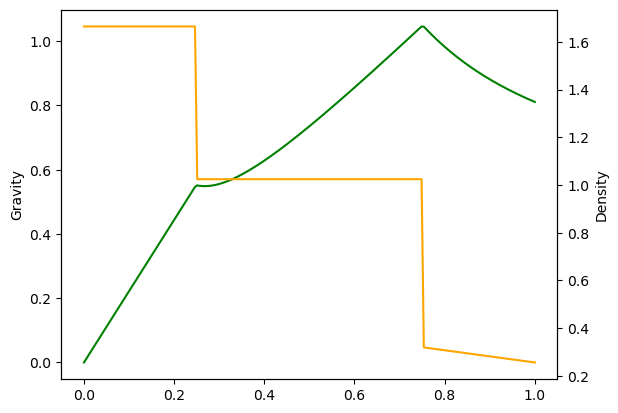

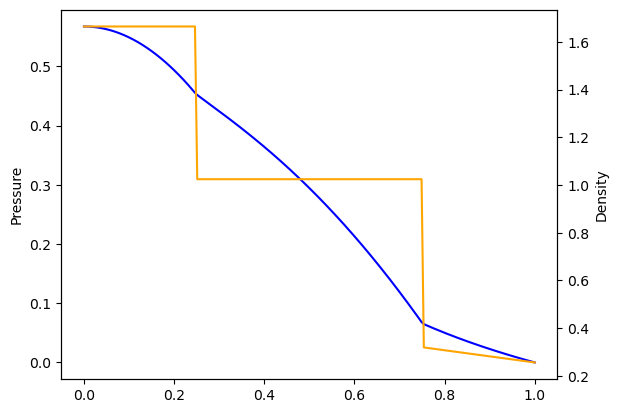

In [6]:
import matplotlib.pyplot as plt

fig1, ax11 = plt.subplots()
ax12 = ax11.twinx()
ax11.plot(radius_array_arr, y_result_arr[0], c='g')
ax12.plot(radius_array_arr, density_array_arr, c='orange')
ax11.set(ylabel='Gravity')
ax12.set(ylabel='Density')


fig2, ax21 = plt.subplots()
ax22 = ax21.twinx()
ax21.plot(radius_array_arr, y_result_arr[1], c='b')
ax22.plot(radius_array_arr, density_array_arr, c='orange')
ax21.set(ylabel='Pressure')
ax22.set(ylabel='Density')

print(f"Centeral Pressure = {y_result_arr[1][0]:0.5e}")
print(f"Surface Gravity = {y_result_arr[0][-1]:0.5e}")

In [7]:
%timeit run()

849 µs ± 8.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
